In [1]:
# Raster I/O and math
import rasterio
from rasterio.warp import calculate_default_transform
from rasterstats import zonal_stats

# Image processing
import numpy as np
from skimage import exposure
import cv2

# Blob detection
from math import sqrt
from skimage.feature import blob_log

# Others
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
from geopy.geocoders import Nominatim
from tqdm import tqdm

# Read in the Gridded Population and Black Marble rasters

In [2]:
GPW_PATH = '../raster/Resampled_BlackMarble_GPW/gpw_v4_population_count_20151.tif'
BM_PATH = '../raster/Resampled_BlackMarble_GPW/BlackMarble_mosaic_resample_32BIT_normalize.tif'

In [3]:
with rasterio.open(GPW_PATH) as src:
    
    # The profile contains the metadata
    GPW_profile = src.profile
    
    # Read the first and only band into an array
    GPW = src.read(1)

In [4]:
with rasterio.open(BM_PATH) as src:
    
    # The profile contains the metadata
    BM_profile = src.profile
    
    # Read the first and only band into an array
    BM = src.read(1)

# Image processing

### Replace huge negative `nodata` values with zeros

In [5]:
GPW[ GPW < -10000000000 ] = 0
BM[ BM < -10000000000 ] = 0

### Remove the concept of `nodata`

In [6]:
del GPW_profile['nodata']
del BM_profile['nodata']

### Normalization by Scaling Between 0 and 1

In [7]:
def min_max_scaler(A):
    results = (A - A.min()) / (A.max() - A.min())
    return results

GPW_scaled = min_max_scaler(GPW)
BM_scaled = min_max_scaler(BM)

### Smooth images with Gaussian Blur

GPW gets a bigger kernel to compensate for the fact that Black Marble is already somewhat blurred.

In [8]:
GPW_kernel_size = (15,15)
GPW_gaussian = cv2.GaussianBlur(GPW_scaled,GPW_kernel_size,0)

In [9]:
BM_kernel_size = (11,11)
BM_gaussian = cv2.GaussianBlur(BM_scaled,BM_kernel_size,0)

### Contrast Stretching

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

In [10]:
def contrast_stretch(img, pmin, pmax):
    pmin, pmax = np.percentile(img, (pmin, pmax))
    img_rescale = exposure.rescale_intensity(img, in_range=(pmin, pmax))
    return img_rescale

In [11]:
GPW_gaussian_enhanced = contrast_stretch(GPW_gaussian, 0.75, 99.25)

In [12]:
BM_gaussian_enhanced = contrast_stretch(BM_gaussian, 0.075, 99.925)

# Calculate difference between the rasters

First we calculate Gridded Population of the World minus Black Marble.

In [13]:
GPW_minus_BM = GPW_gaussian_enhanced - BM_gaussian

Save to geotiff.

In [14]:
GPW_minus_BM_profile = GPW_profile

with rasterio.open('GPW_minus_BM_smoothed.tif', 'w', **GPW_minus_BM_profile) as dst:
    dst.write(GPW_minus_BM, 1)

/anaconda/envs/venice/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


We also calculate Black Marble minus Gridded Population of the World (it will be handy to have this as a separate array for blob detection).

In [15]:
BM_minus_GPW = -1 * GPW_minus_BM

# More people than lights

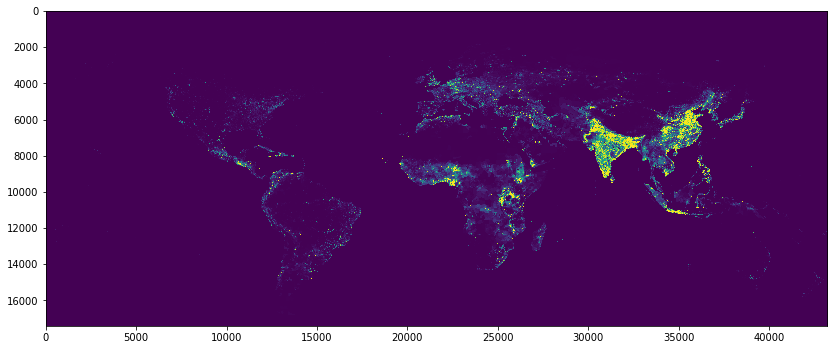

In [16]:
GPW_minus_BM_gte_0 = GPW_minus_BM.copy()
np.place(GPW_minus_BM_gte_0, GPW_minus_BM_gte_0<0, 0)
plt.figure(figsize=(14,8))
plt.imshow(GPW_minus_BM_gte_0, cmap="viridis", interpolation='nearest')
plt.show()

Save to geotiff.

In [17]:
GPW_minus_BM_path = 'GPW_minus_BM_gte_0.tif'
with rasterio.open(GPW_minus_BM_path, 'w', **GPW_profile) as dst:
    dst.write(GPW_minus_BM_gte_0, 1)

# More lights than people

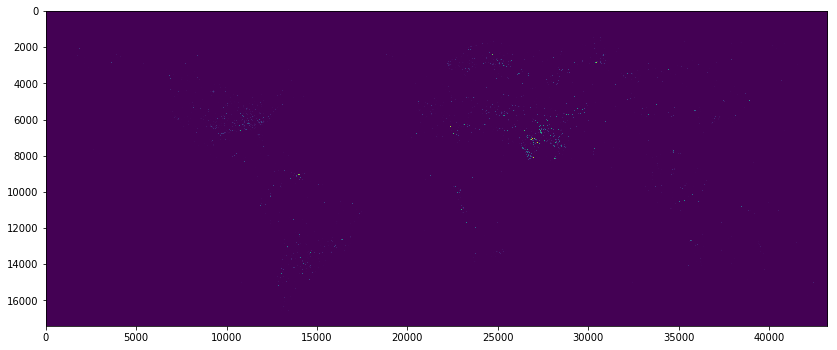

In [18]:
BM_minus_GPW_gte_0 = BM_minus_GPW.copy()
np.place(BM_minus_GPW_gte_0, BM_minus_GPW_gte_0<0, 0)
plt.figure(figsize=(14,8))
plt.imshow(BM_minus_GPW_gte_0, cmap="viridis", interpolation='nearest')
plt.show()

Save to geotiff.

In [19]:
BM_minus_GPW_path = 'BM_minus_GPW_gte_0.tif'
with rasterio.open(BM_minus_GPW_path, 'w', **GPW_profile) as dst:
    dst.write(BM_minus_GPW_gte_0, 1)

# Blob Detection by Place Name

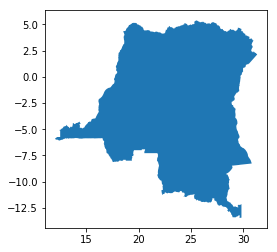

In [20]:
polygon = ox.gdf_from_place("Democratic Republic of Congo")
polygon.plot();

In [21]:
GPW_minus_BM_stats = zonal_stats(
                        polygon,
                        GPW_minus_BM_path,
                        all_touched=True,
                        add_stats={'maxcell': lambda x: np.unravel_index(x.argmax(), x.shape)},
                        raster_out=True
                    )[0]

/anaconda/envs/venice/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/anaconda/envs/venice/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/anaconda/envs/venice/lib/python2.7/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/anaconda/envs/venice/lib/python2.7/site-packages/rasterstats/main.py:161: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(fsrc.array.dtype, float) and \


Places with more people than lights.

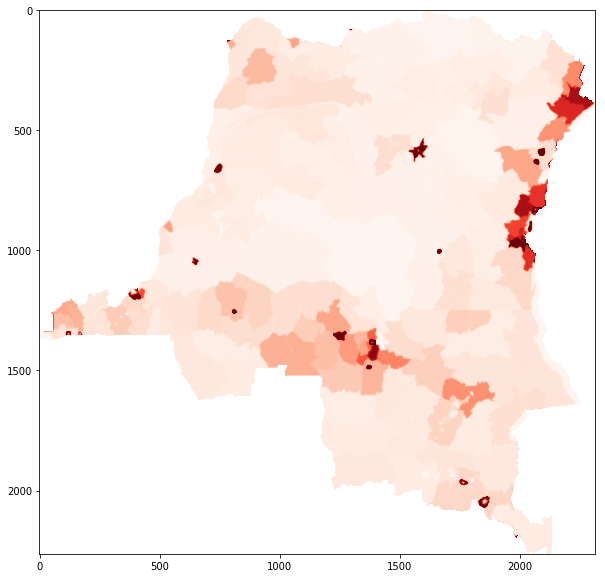

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(GPW_minus_BM_stats['mini_raster_array'], cmap='Reds', interpolation='nearest')
plt.show()

In [23]:
BM_minus_GPW_stats = zonal_stats(
                        polygon,
                        BM_minus_GPW_path,
                        all_touched=True,
                        add_stats={'maxcell': lambda x: np.unravel_index(x.argmax(), x.shape)},
                        raster_out=True
                    )[0]

Places with more lights than people.

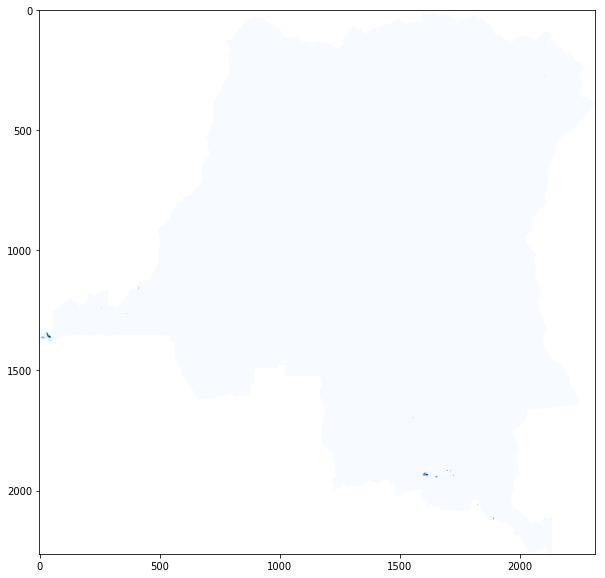

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(BM_minus_GPW_stats['mini_raster_array'], cmap='Blues', interpolation='nearest')
plt.show()

We have the affine transform information leftover from the zonal stats operation.

In [27]:
GPW_minus_BM_stats['mini_raster_affine']

Affine(0.00833333333333339, 0.0, 12.033333333334639,
       0.0, -0.00833333333333339, 5.400000000008646)

In [28]:
def pixel2coord(transform, row, col):
    ''' converts row col to lat, lon'''
    coff, roff = (0.5, 0.5)
    x, y = transform * transform.translation(coff, roff) * (col, row)
    return y, x

The pixel with the most people, least lights:

In [29]:
pixel2coord(GPW_minus_BM_stats['mini_raster_affine'], *GPW_minus_BM_stats['maxcell'])

(4.737500000008642, 22.870833333334712)

The pixel with the most lights, least people:

In [31]:
pixel2coord(BM_minus_GPW_stats['mini_raster_affine'], *BM_minus_GPW_stats['maxcell'])

(-5.929166666658098, 12.395833333334641)

In [32]:
def detect_blobs(array, color, cmap=None):
    
    array.mask = False
    
    blobs = blob_log(array, max_sigma=30, num_sigma=10, threshold=.1)
    # Compute blob radius in the 3rd column.
    blobs[:, 2] = blobs[:, 2] * sqrt(2)
    
    title = 'Laplacian of Gaussian. $max \sigma = 20$, $num = 10$'

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})

    ax.set_title(title, fontsize=20)
    ax.imshow(array, interpolation='nearest', cmap=cmap)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

    plt.tight_layout()
    plt.show()
    
    # Convert pixels to lat, lons
    blob_coords = [pixel2coord(GPW_minus_BM_stats['mini_raster_affine'], i[0], i[1]) for i in blobs]
    
    return blob_coords

# People no Lights

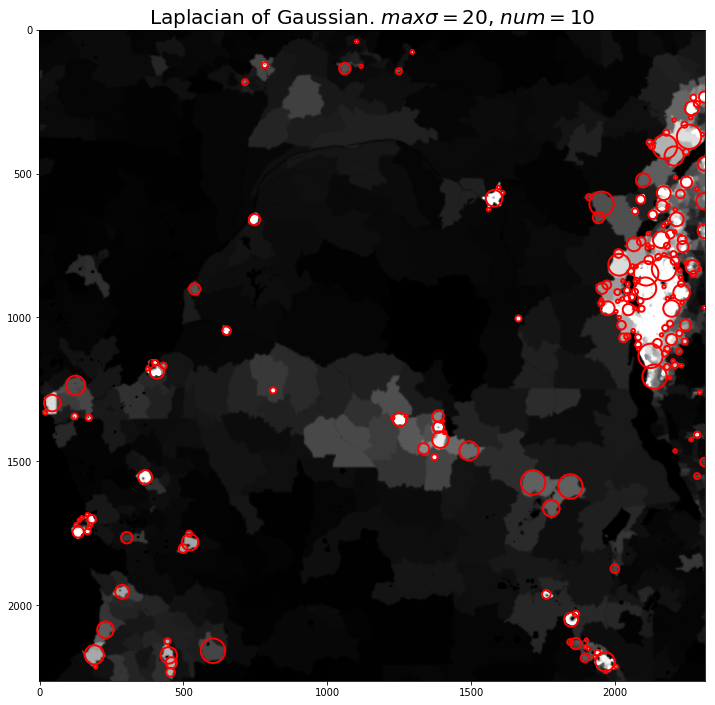

In [33]:
people_no_lights = detect_blobs(GPW_minus_BM_stats['mini_raster_array'], color='red', cmap='gray')

In [34]:
print len(people_no_lights), "people-no-lights blobs found"

215 people-no-lights blobs found


# Lights no People

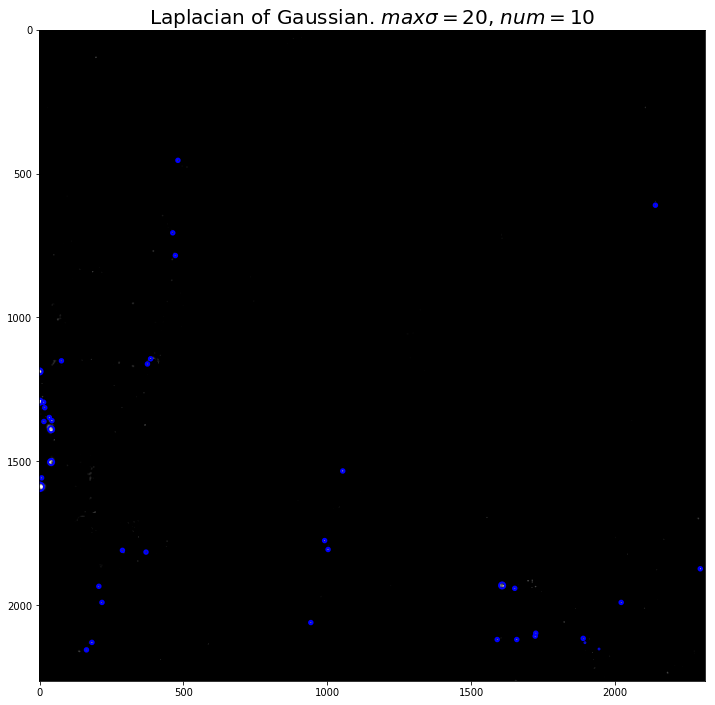

In [35]:
lights_no_people = detect_blobs(BM_minus_GPW_stats['mini_raster_array'], color='blue',cmap='gray')

In [36]:
print len(lights_no_people), "lights-no-people blobs found"

39 lights-no-people blobs found
